In [1]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=1)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 26.92 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.35.2
Using datasets v2.15.0
Using accelerate v0.25.0
Using sentencepiece v0.1.99
Using sacremoses v0.1.1
No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.


# 1. 트랜스포머 소개
##### 구글에서 2017년 시퀀스 모델링을 위한 새로운 신경망인 트랜스포머(Transformer)란 아키텍처를 제안했다. 해당 아키텍처는 기존 순환 신경망(RNN)에 비해 품질과 비용 측면에서 더 뛰어났다.
##### 동시에 효율적인 전이 학습 방법인 ULMFiT가 매우 큰 말뭉치에서 LSTM 신경망을 훈련해 매우 적은 양의 레이블링된 데이터로도 높은 구준의 텍스트 분류 모델을 만들어낼수 있었다.
##### 이런 트랜스포머의 발전이 GPT와 BERT를 릴리스할 수 있게 되었다.
##### 해당 모델들은 트랜스포머 아키텍처와 비지도 학습을 결합해 모델을 밑바닥부터 훈련할 필요가 없게 하여 NLP 벤치마크에서 큰 차이로 기록을 경신했다.
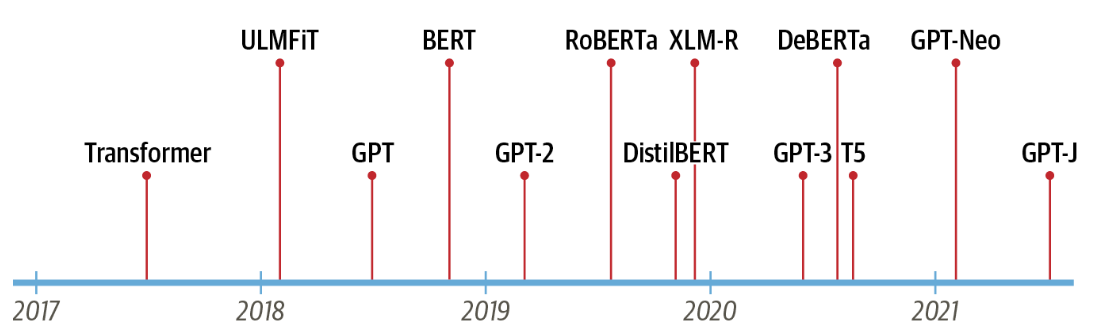
##### 트랜스포머의 새로운 점을 이해할려면 아래 세 가지 점을 이해해야한다.
##### - 인코더 - 디코더 프레임워크
##### - 어텐션 메커니즘
##### - 전이 학습
##### 이렇게 트랜스포머의 기초가 되는 핵심 개념을 소개하고 어떻게 작업이 돌아가는 지 확인한다. 그리고 마지막으로 허깅페이스 생태계의 도구와 라이브러리를 알아볼 것이다.

## 1.1 인코더-디코더 프레임워크
##### 트랜스포머가 등장하기 전, LSTM 같은 순환 신경망 구조가 최고 수준의 성능을 달성했다.
##### 순환 신경망 구조에는 정보를 한 스텝에서 다음 스텝으로 전파하도록 네트워크에 피드백 루프가 포함된다. 이런 구조는 텍스트와 같은 순차 데이터를 모델링하는데 이상적이다.
##### 아래 그림을 보면 RNN은 입력을 받아 네트워크를 통과시킨 후 **은닉 상태**라는 벡터를 출력한다. 동시에 출력된 정보를 피드백 루프로 보내 자기 자신을 다시 입력한다. 이런 과정을 거쳐 RNN은 출력한 정보의 일부를 다음 스텝에 사용하게 된다.
##### 즉, RNN은 각 스텝에서 상태에 대한 정보를 시퀀스의 다음 작업으로 전달한다. 이런 식으로 이전 스텝의 정보를 추적하고 이를 사용해 예측을 만든다.
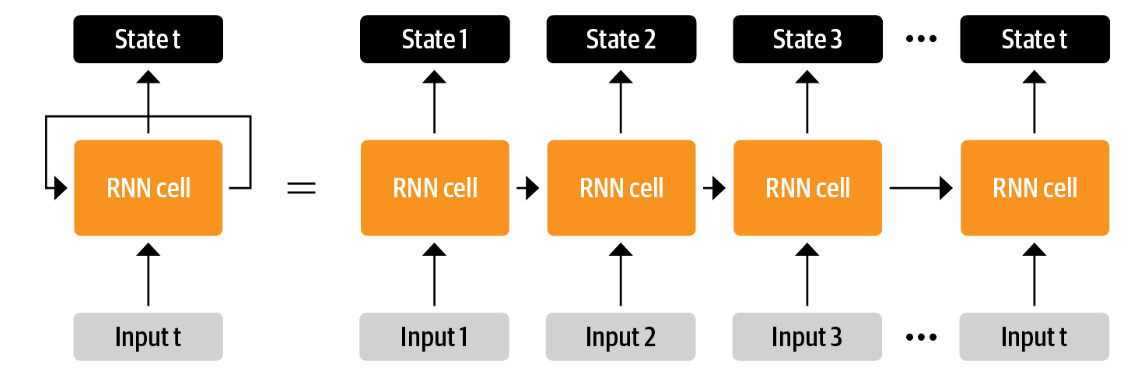


##### RNN은 단어 시퀀스를 한 언어에서 다른 언어로 매핑하는 기계 번역 시스템을 개발할 때 중요한 역할을 했다. 이런 종류의 작업은 대게 **인코더-디코더** 또는 **시퀀스-투-시퀀스** 구조로 처리하며 입력과 출력이 임의의 길이를 가진 시퀀스일 때 잘 맞다.
##### 인코더는 입력 시퀀스의 정보를 **마지막 은닉 상태**라고도 부르는 수치 표현으로 인코딩한다. 그다음 이 상태가 디코더로 전달되어 출력 시퀀스가 생성된다.
##### 아래 그림에서 영어 문장 "Transformers are great!"을 은닉 상태 벡터로 인코딩한 다음, 이를 디코딩해 독일어 문장 "Transformer sind grossartig!"으로 만든 한 쌍의 RNN이다.
##### 입력 단어는 순차적으로 인코더에 주입되고 출력 단어는 위에서 아래 방향으로 한 번에 하나씩 생성된다.
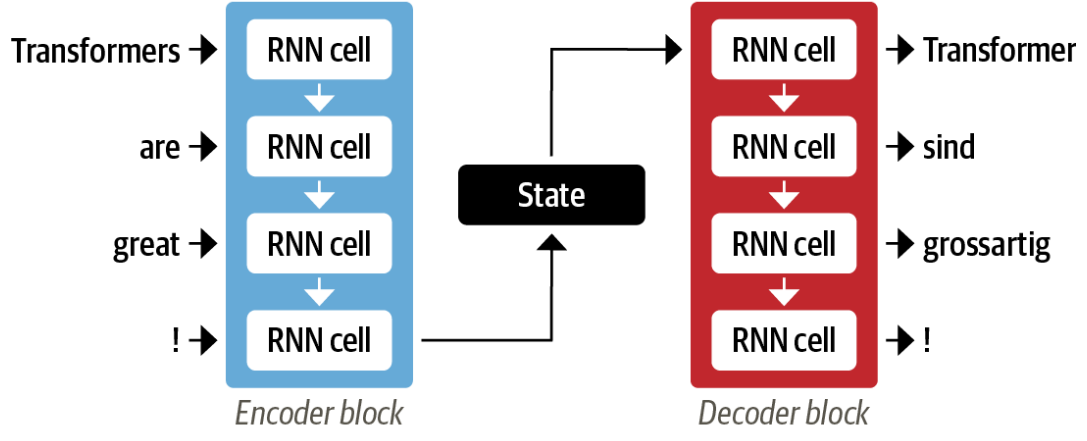

##### 간결하지만, 이 구조는 인코더의 마지막 은닉 상태가 **정보 병목**이 된다는 약점이 있다.
##### 디코더는 인코더의 마지막 은닉 상태만을 참조해 출력을 만들므로 여기에 전체 시퀀스의 의미가 담겨있어야 한다. 시퀀스가 긴 경우, 모든 것을 고정된 하나의 표현으로 압축하는 과정에서 시작 부분의 정보가 손실될 가능성 있어 취약하다
##### 다행히 디코더가 인코더의 모든 은닉 상태에 접근해 이 병목을 제거한다. 이런 일반적인 메커니즘을 어텐션이라고 한다. 이것이 최신 신경망 구조의 핵심 구성 요소이다.

## 1.2 어텐션 매커니즘
##### 어텐션은 입력 시퀀스에서 은닉 상태를 만들지 않고 스텝마다 인코더에서 디코더가 참고할 은닉 상태를 출력한다는 주요 개념을 기초한다.
##### 하지만 모든 상태를 동시에 사용하려면 디코더에 많은 입력이 발생하므로 어떤 상태를 먼저 사용할 지 우선순위를 정하는 매커니즘이 필요하다.
##### 디코더가 모든 디코딩 타입 스텝마다 인코더의 각 상태에 다른 가중치 또는 '어텐션'을 할당한다.
##### 아래 그림에서 어텐션은 출력 시퀀스에 있는 두 번째 토큰을 예측하는 역할을 한다.
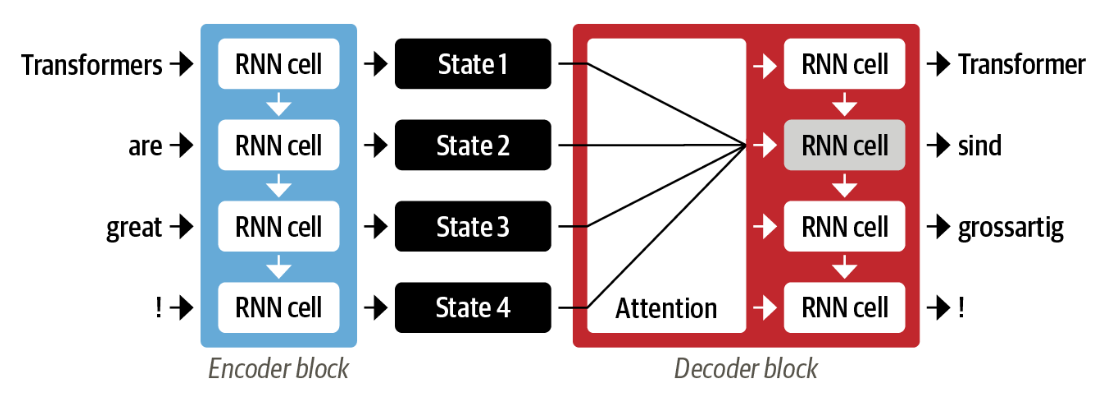
##### 어텐션 기반 모델은 타입스텝마다 가장 많이 관련된 입력 토큰에 초점을 맞추므로 번역 문장에 있는 단어와 원 문장에 있는 단어의 복잡한 정렬 문제를 학습한다.
##### 예를 들어, 아래 사진은 영어-프랑스어 변역 모델의 어텐션 가중치를 보여준다. 여기서 각 픽셀은 각각의 가중치를 나타낸다. 'zone'과 'Area'를 디코더가 어떻게 올바르게 정렬하는지 보여준다.
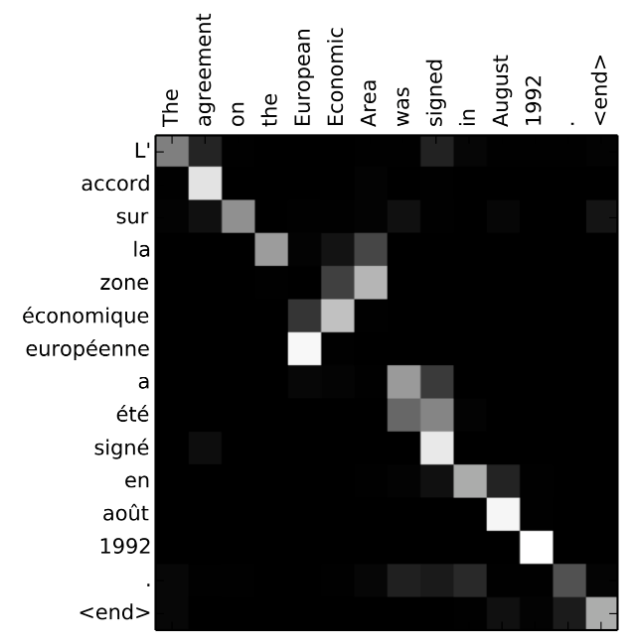

##### 어텐션으로 번역이 한결 좋아졌지만, 인코더와 디코더에 사용하는 순환 모델의 단점은 여전히 존재한다.
##### 태생적으로 순차적으로 수행되며 입력 시퀀스를 전체에 걸쳐 병렬화할 수 없다.
##### 그래서, 순환을 모두 없애고 **셀프 어텐션**이라는 특별한 형태의 어텐션에 의지한다.
##### 기본적으로 신경망의 같은 층에 있는 모든 상태에 대해서 어텐션을 작동하는 방식이다.
##### 아래 그림에 있는 인코더와 디코더는 각각 셀프 어텐션이 있다. 어텐션의 출력은 피드 푸워드 신경망(FFNN)에 주입된다. 이 구조는 순환 모델보다 더 빠르게 훈련하며 최근 NLP 분야에서 대단한 혁신이다.
#####  피드 푸워드 신경망 : 노드 간의 연결이 순환을 형성하지 않는 인공 신경망
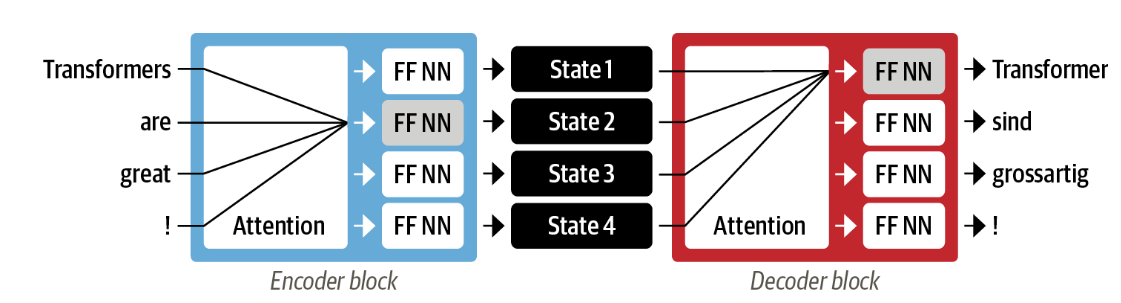

##### 트랜스포머 원래 논문에서는 처음부터 대량의 데이터로 구성된 대규모 말뭉치에서 번역 모델울 훈련했다.
##### 하지만, 많은 실용적인 NLP 애플리케이션이 모델 훈련에 사용할 레이블린된 대규모 텍스트 데이터를 구할 수 없다.
##### 그래서 전이 학습 사용한다.

## 1.3 NLP의 전이 학습
##### 요즘 컴퓨터 비전(CV)에서는 전이 학습을 사용해 ResNet 같은 합성곱 신경망을 한 작업에서 훈련한 다음 새로운 작업에 적용하거나 미세 튜닝을 한다. 이를 통해 신경망은 원래 작업에서 학습한 지식을 공유한다.
##### 구조적으로 볼 때 모델은 바디와 헤드로 나뉜다. 바디의 가중치는 훈련하는 동안 원래 도메인에서 다양한 특성을 학습하고, 이 가중치를 사용해 새로운 작업을 위한 모델을 초기화한다.
##### 전통적인 지도 학습과 비교하여 적은 양의 레이블 데이터로 높은 품질의 모델을 만든다.
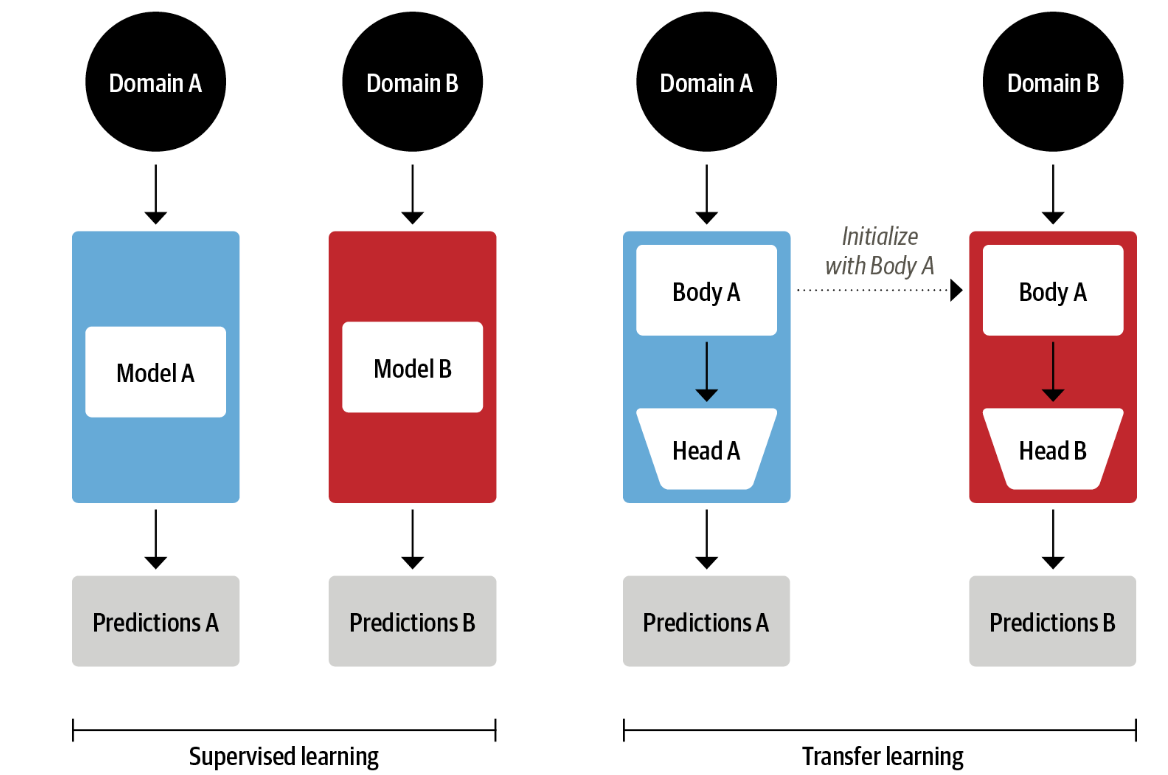

##### 컴퓨터 비전에서는 먼저 이미지가 수백만 개인 ImageNet 같은 대규모 데이터셋에서 모델을 훈련한다. 이 과정이 **사전 훈련**이며, 모델에게 에지나 색깔 같은 기본적인 이미지 특징을 가르치는 것이다.
##### 그 다음 사전 훈련된 모델을 후속 작업에서 미세 튜닝할 수 있다. 미세 튜닝한 모델은 일반적으로 처음부터 동일한 양의 레이블링된 데이터에서 훈련하는 지도 학습 모델보다 정확도가 더 높다.
##### OpenAI 연구원들이 감성 분류 작업에 비지도 사전 훈련에서 추출한 특성을 사용해 높은 성능을 얻으며 소개된 방식이다. ULMFiT는 다양한 작업에 사전 훈련된 LSTM 모델을 적용한다.
##### ULMFiT는 세 개의 주요 단계로 구성된다.

### 사전 훈련
##### 초기 훈련의 목표는 간단하다. 이전 단어를 바탕으로 다음 단어를 예측하는 것이다. 이 작업을 **언어 모델링**이라 한다.
##### 편리하게도 이 작업은 레이블링된 데이터가 필요하지 않으므로 풍부한 텍스트를 활용한다.(위키피디아)


### 도메인 적용
##### 언어 모델을 대규모 말뭉치에서 사전 훈련한 후, 다음 단계로 도메인 내 말뭉치에 적응시킨다. 여전히 언어 모델링을 사용하지만 이제 모델은 타킷 말뭉치에 있는 다음 단어를 예측한다.


### 미세튜닝
##### 이 단계에서 언어 모델을 타깃 작업을 위한 분류 층과 미세 튜닝한다.
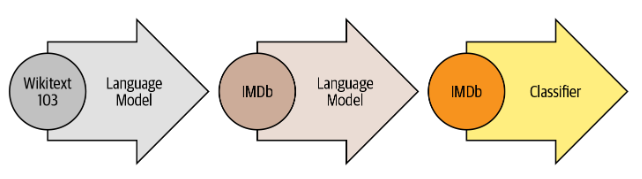

##### 2018년 셀프 어텐션과 전이 학습을 결합한 두 개의 트랜스포머 모델이 릴리스 되었다.
### GPT
##### 트랜스포머 아키텍처의 디코더 부분만 사용하고 ULMFiT 같은 언어 모델링 방법을 사용한다.

### BRET
##### 트랜스포머 아키텍처의 인코더 부분을 사용하고 **마스크드 언어 모델링**이라는 특별한 형태의 언어 모델링을 사용한다. 마스크드 언어 모델링의 목표는 텍스트에서 랜덤하게 마스킹된 단어를 예측하는 것이다.
##### 예를 들어, 'I looked at my [MASK] and saw that [MASK] was late'라는 문장에서 모델은 [MASK]로 마스킹된 단어에 대해 가장 가능성이 높은 후보를 예측한다.

##### GPT와 BERT는 다양한 NLP 벤치마크에서 기록을 새롭게 경신하며 트랜스포머 시대를 열었다.
##### 하지만 연구실마다 호환되지 않는 프레임워크를 사용해 모델을 릴리스했고, 자신의 애플리케이션에 포팅하기가 쉽지 않다.
##### 그래서 허깅페이스 트랜스포머스가 릴리스 되면서 단일화된 API로 쉽게 사용할 수 있게 되었다.

## 1.4 허깅페이스 트랜스포머스
##### 새로운 머신러닝 아키텍처를 새로운 작업에 적용하는 일은 복잡한 작업으로, 일반적으로 아래와 같은 단계를 거친다.
##### 1. 모델 아키텍처를 코드로 구현합니다. 전형적으로 파이토치 또는 텐서플로를 사용합니다.
##### 2. 서버로부터 사전 훈련된 가중치를 로드합니다.
##### 3. 입력을 전처리하고 모델에 전달합니다. 그 다음 해당 작업에 맞는 사후 처리를 수행합니다.
##### 4. 데이터로더를 구현하고 모델 훈련을 위해 손실 함수와 옵티마이저를 정의합니다.

##### 모델과 작업에 따라 단계마다 별도의 사용자 정의 로직이 필요하다. 새로운 논문을 낼 때 코드와 모델 가중치도 관행적으로 함께 릴리스를 하지만 코드가 표준화되어 있지 않아서 새로운 문제에 적용하기 위해 오랜 시간이 걸린다.
##### 이러한 배경에서 허깅페이스는 모델에 표준화된 인터페이스를 제공해주고, 주요 딥러닝 프레임워크(파이토치, 텐서플로, JAX)를 지원하며 프레임워크 전환에 용이하다.
##### 그리고 텍스트 분류, 개체명 인식, 질문 답변 같은 후속 작업에 트랜스포머를 미세 튜닝하기도 쉽다. -> 개발자들이 여러 모델을 훈련하고 테스트하는 시간이 극단적으로 줄어들었다.

## 1.5 트랜스포머 애플리케이션 둘러보기
##### 텍스트가 고객 피드백이라면 긍정적인 피드백인지 부정적인 피드백인지 알고 싶어 하는데, 이런 작업을 **감성 분석**이라 하는데, 이는 2장에서 광범위하게 살펴볼 **텍스트 분류**에 속한다.
##### 여기서는 트랜스포머스를 사용해 예시 텍스트의 감성을 분류하는 방법에 대해서 살펴보자.

In [2]:
text = """Dear Amazon, last week I ordered an Optimus Prime action figure \
from your online store in Germany. Unfortunately, when I opened the package, \
I discovered to my horror that I had been sent an action figure of Megatron \
instead! As a lifelong enemy of the Decepticons, I hope you can understand my \
dilemma. To resolve the issue, I demand an exchange of Megatron for the \
Optimus Prime figure I ordered. Enclosed are copies of my records concerning \
this purchase. I expect to hear from you soon. Sincerely, Bumblebee."""

### 1.5.1 텍스트 분류
##### 트랜스포머스는 다양한 추상화 수준에서 라이브러리와 상호작용하도록 계층화된 API를 제공한다.
##### 이 장에서는 원시 텍스트를 미세 튜닝된 모델의 예측으로 변환하기 위해 필요한 모든 단계를 추상화하는 **파이프라인**을 사용할 것이다.
##### 트랜스포머스에서는 **pipeline()** 함수를 호출하면서 관심 작업 이름을 전달해 파이프라인 객체를 만든다.

In [3]:
from transformers import pipeline

classifier = pipeline("text-classification")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

##### 처음 이 코드를 실행하면 파이프라인이 자동으로 허깅페이스 허브에서 모델 가중치를 다운로드 한다.
##### 기본적으로 text-classification 파이프라인은 감성 분석을 위해 설계된 모델을 사용하지만, 다중 분류와 다중 레이블 분류도 지원한다.
##### 예측을 만들어보자

In [4]:
import pandas as pd

outputs = classifier(text)
pd.DataFrame(outputs)

,label,score
0,NEGATIVE,0.901546


### 1.5.2 개체명 인식
##### NLP에서는 제품, 장소, 사람 같은 실제 객체를 **개체명**이라고 하고 이런 개체명을 텍스트에서 추출하는 작업을 **개체명 인식(NER)**이라 한다.

In [5]:
ner_tagger = pipeline("ner", aggregation_strategy="simple")
outputs = ner_tagger(text)
pd.DataFrame(outputs)

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

,entity_group,score,word,start,end
0,ORG,0.879011,Amazon,5,11
1,MISC,0.990859,Optimus Prime,36,49
2,LOC,0.999755,Germany,90,97
3,MISC,0.556571,Mega,208,212
4,PER,0.590256,##tron,212,216
5,ORG,0.669693,Decept,253,259
6,MISC,0.498349,##icons,259,264
7,MISC,0.775362,Megatron,350,358
8,MISC,0.987854,Optimus Prime,367,380
9,PER,0.812096,Bumblebee,502,511


##### 해당 파이프라인은 모든 개체명을 감지하고 ORG(조직), LOC(위치), PER(사람) 같은 카테고리에 할당했다.

### 1.5.3 질문 답변
##### 질문 답변에서는 텍스트 구절과 함께 답을 얻고 싶은 질문을 모델에 전달하고, 모델은 답변 텍스트를 반환한다.

In [7]:
reader = pipeline("question-answering")
question = "What does the customer want?"
outputs = reader(question=question, context=text)
pd.DataFrame([outputs])

,score,start,end,answer
0,0.631292,335,358,an exchange of Megatron


##### 질문 답변에는 여러 유형이 있는데, 자세한건 7장에서 알아볼 것이다.
##### 해당 유형은 답변을 텍스트에서 직접 추출하기 때문에 **추출적 질문 답변**이라고 한다.

### 1.5.4 요약
##### 텍스트 요약의 목표는 긴 텍스트를 입력으로 받고 관련 사실이 모두 포함된 간단한 버전을 생성하는 것이다.
##### 모델이 논리적인 텍스트를 생성해야 하므로 이전 문제보다 훨씬 더 복잡한 작업이다.

In [8]:
summarizer = pipeline("summarization")
outputs = summarizer(text, max_length=45, clean_up_tokenization_spaces=True)
print(outputs[0]['summary_text'])

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1298: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (45). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


 Bumblebee ordered an Optimus Prime action figure from your online store in
Germany. Unfortunately, when I opened the package, I discovered to my horror
that I had been sent an action figure of Megatron instead.


### 1.5.5 번역
##### 번역 파이프라인을 사용하여 영어 텍스트를 독일어로 번역하자

In [11]:
translator = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de")
outputs = translator(text, clean_up_tokenization_spaces=True, min_length=100)
print(outputs[0]['translation_text'])

Sehr geehrter Amazon, letzte Woche habe ich eine Optimus Prime Action Figur aus
Ihrem Online-Shop in Deutschland bestellt. Leider, als ich das Paket öffnete,
entdeckte ich zu meinem Entsetzen, dass ich stattdessen eine Action Figur von
Megatron geschickt worden war! Als lebenslanger Feind der Decepticons, Ich
hoffe, Sie können mein Dilemma verstehen. Um das Problem zu lösen, Ich fordere
einen Austausch von Megatron für die Optimus Prime Figur habe ich bestellt.
Eingeschlossen sind Kopien meiner Aufzeichnungen über diesen Kauf. Ich erwarte,
von Ihnen bald zu hören. Aufrichtig, Bumblebee.


### 1.5.6 텍스트 생성


In [12]:
generator = pipeline("text-generation")
response = "Dear Bumblebee, I am sorry to hear that your order was mixed up."
prompt = text + "\n\nCustomer service response:\n" + response
outputs = generator(prompt, max_length=200)
print(outputs[0]['generated_text'])

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Dear Amazon, last week I ordered an Optimus Prime action figure from your online
store in Germany. Unfortunately, when I opened the package, I discovered to my
horror that I had been sent an action figure of Megatron instead! As a lifelong
enemy of the Decepticons, I hope you can understand my dilemma. To resolve the
issue, I demand an exchange of Megatron for the Optimus Prime figure I ordered.
Enclosed are copies of my records concerning this purchase. I expect to hear
from you soon. Sincerely, Bumblebee.

Customer service response:
Dear Bumblebee, I am sorry to hear that your order was mixed up. I ordered 3
Optimus Prime action figures today. My question to you to address the issue is
to get the wrong release date or exact pricing for it. In my memory, you have a
nice collection of Transformers films and cartoons that have never been released
in print. Although not the highest quality, they are great characters that
should be seen on


## 1.6 허깅페이스 생태계
##### 허깅페이스 생태계는 크게 라이브러리와 허브로 구성된다. 라이브러리는 코드를 제공하고, 허브는 사전 훈련된 모델 가중치, 데이터셋, 평가 지표를 위한 스크립트 등을 제공한다.
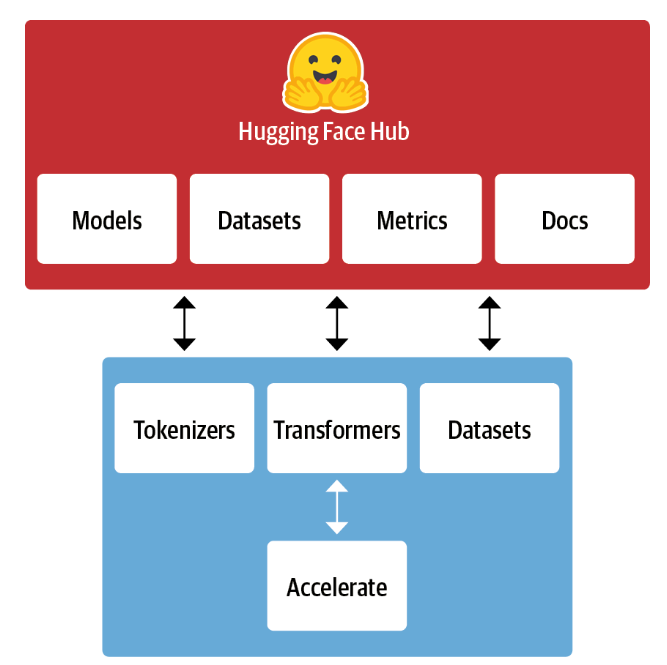

### 1.6.1 허깅페이스 허브
##### 허브는 사전 훈련된 모델을 빠르게 로드하고 실험할 수 있다. 또, 모델과 데이터셋 내용을 문서화한 모델 카드와 데이터셋 카드도 제공하므로 자신에게 적합한지 결정해서 사용할 수 있다.
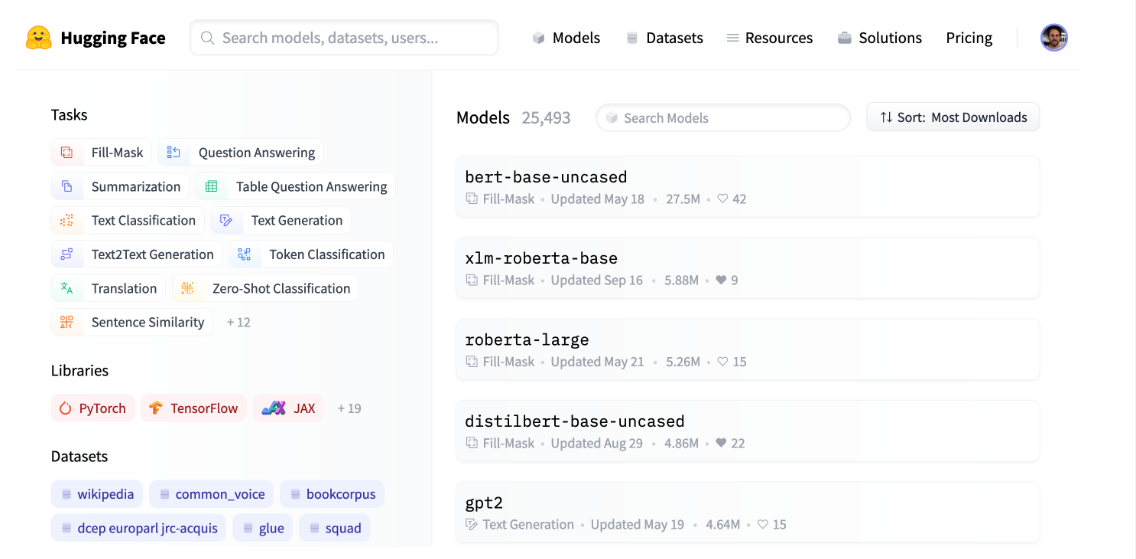
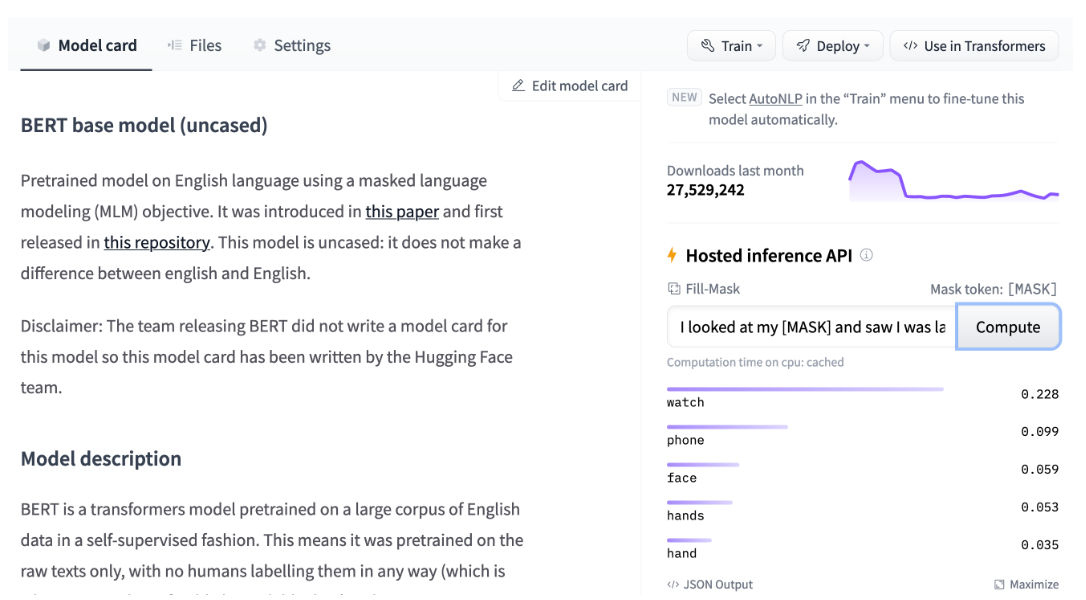

### 1.6.2 허깅페이스 토크나이저
##### 토크나이저는 다양한 토큰화 전략을 제공하는데, 러스트 백엔드 덕분에 매우 빠르게 텍스트를 토근화한다. 또 입력을 정규화하거나 모델 출력을 적절한 포맷으로 변환하는 등의 모든 전처리, 사후처리 단계를 처리한다.
##### 토크나이저를 사용하면 트랜스포머스로 사전 훈련된 모델 가중치를 로드하는 방식으로 토크나이저를 로드할 수 있다.

### 1.6.3 허깅페이스 데이터셋
##### 데이터셋은 허브에서 찾을 수 있는 수천 개의 데이터셋에 대한 표준 인터페이스를 제공해 단순화한다.
##### 스마트한 캐싱을 제공하고 메모리 매핑이라는 특별한 매커니즘을 활용해 램 부족을 피한다.
* 메모리 매핑 : 파일 내용을 가상 메모리에 저장하고 여러 개의 프로세스로 더 효율적으로 파일을 수정한다.

### 1.6.4 허깅페이스 액셀러레이트
##### 액셀러레이트는 사용자 정의 로직을 처리하는 일반적인 훈련 루프에 훈련 인프라에 필요한 추상화 층을 추가한다.
##### 말그대로 필요한 인프라 전환을 단순화해 워크플로를 가속화한다.

## 1.7 트랜스포머의 주요 도전 과제
##### 1. 언어
##### - NLP 연구에 사용된 언어는 거의 영어이다. 다중 언어 트랜스포머와 제로샷 교차 언어 전이를 수행하는 능력은 4장에서 살펴볼 것이다.
##### 2. 데이터 가용성
##### - 모델에 필요한 레이블링된 훈련 데이터의 양은 전이 학습을 사용하면 크게 줄지만 사람이 작업을 수행하는 데 필요한 양에 비하여 여전히 많다. 레이블링된 데이터가 없거나 소량인 경우는 9장에서 살펴볼 것이다.
##### 3. 긴 문서 처리하기
##### - 셀프 어텐션은 텍스트 길이가 문단 정도 될 때 잘 동작합니다. 하지만 문서와 같이 긴 텍스트에서 사용할려면 비용이 많이 든다. 해당 경우는 11장에서 완화하는 방법을 살펴볼 것이다.
##### 4. 불투명성
##### - 트랜스포머는 다른 딥러닝 모델처럼 대부분 투명하지 않다. 모델이 그렇게 예측한 이유를 설명하기가 어렵거나 불가능하다. 불투명성은 모델로 중요한 결정을 내릴 때 특히 문제가 된다. 2장과 4장에서 트랜스포머 모델의 오류를 조사하는 몇 가지 방법에 대해서 알아볼 것이다.
##### 5. 편향
##### - 트랜스포머 모델은 주로 인터넷의 텍스트 데이터를 사용해 사전 훈련을 한다. 따라서 이런 데이터에 있는 편향이 모델에 고스란히 전이된다. 인종차별, 성차별 등의 더 나쁜 편향의 유무를 확인하는 일은 어렵다. 이 문제는 10장에서 알아볼 것이다.